# Imports and Setup

In [41]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
import gan_protein_structural_requirements.utils as utils
from gan_protein_structural_requirements.utils.protein_visualizer import jupy_viz_obj as jvo, jupy_viz_file as jvf
from gan_protein_structural_requirements.utils.folding_models import esm_batch_predict as esm_batch_predict, esm_predict as esm_predict, load_tokenizer as load_tokenizer
from gan_protein_structural_requirements.utils.extract_structure import extract_structures as extract_structures, untokenize as untokenize, get_untokenizer as get_untokenizer
from gan_protein_structural_requirements.data import class_ccc_progan_dataset as cdt
import gan_protein_structural_requirements.utils.folding_models as fold
from gan_protein_structural_requirements.models import networks
from gan_protein_structural_requirements.models.seqtovec_model import SeqToVecModel
from gan_protein_structural_requirements.train import train_seqtovec
from gan_protein_structural_requirements.test import test_seqtovec
from gan_protein_structural_requirements.data.class_ccc_progan_eval_dataset import Eval_Protein_dataset as edt

import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader

# Data Analysis

### Load Train Dataset

In [19]:
dtst = cdt.Protein_dataset(
    root_dir="/Users/rohitkulkarni/Documents/gan_protein_structural_requirements/gan_protein_structural_requirements/data/raw/train",
    min_prot_len=200,
    max_prot_len=1024
    )

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/Bio/PDB/DSSP.py:199: UserWarning: no atoms read before TER record 
TER    8879      TYR F1006                                                      
no atoms read before TER record 
TER    8947      TYR H1006                                                      
no atoms read before TER record 
TER    9015      TYR J1006                                                      
no atoms read before TER record 
TER    9083      TYR L1006                                                      

  warnings.warn(err)
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/Bio/PDB/DSSP.py:199: UserWarning: DSSP could not be created due to an error:
empty protein, or no valid complete residues

  warnings.warn(err)
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/Bio/PDB/DSSP.py:199: UserWarning: DSSP could not be created due to an error:
empty protein, or no val

### Load Test Dataset

In [30]:
eval_dtst = edt(
    root_dir="/Users/rohitkulkarni/Documents/gan_protein_structural_requirements/gan_protein_structural_requirements/data/raw/test",
    min_prot_len=200,
    max_prot_len=1024)

### Get Pandas DataFrame

In [23]:
data = {"alpha helix":[],"isolated beta-bridge residue":[],"strand":[],"3-10 helix":[],"pi helix":[],"turn":[],"bend":[],"none":[],"polarity proportion":[],"sequence":[]}
for entry in dtst.X[:,0]:
    entry = entry.tolist()
    data["alpha helix"].append(entry[0])
    data["isolated beta-bridge residue"].append(entry[1])
    data["strand"].append(entry[2])
    data["3-10 helix"].append(entry[3])
    data["pi helix"].append(entry[4])
    data["turn"].append(entry[5])
    data["bend"].append(entry[6])
    data["none"].append(entry[7])
    data["polarity proportion"].append(entry[8])
for entry in dtst.Y:
    data["sequence"].append(entry.tolist())

raw_data = pd.DataFrame(data)

### Get Density Curves of Features

array([<Axes: ylabel='Density'>, <Axes: ylabel='Density'>,
       <Axes: ylabel='Density'>, <Axes: ylabel='Density'>,
       <Axes: ylabel='Density'>, <Axes: ylabel='Density'>,
       <Axes: ylabel='Density'>, <Axes: ylabel='Density'>,
       <Axes: ylabel='Density'>], dtype=object)

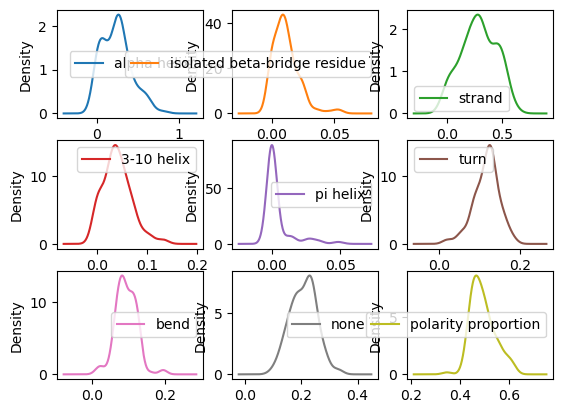

In [24]:
raw_features = raw_data.drop(columns=["sequence"])
fig, axes = plt.subplots(nrows=3, ncols=3)
raw_features.plot.kde(subplots=True, ax=axes)

### Pretrain Sequence to vector model

In [25]:
sequence_dim = 20
max_prot_len = 1024
device = torch.device('cpu')
root_save_dir = "/Users/rohitkulkarni/Documents/gan_protein_structural_requirements/gan_protein_structural_requirements"
model_name = "seqtovec"

#hparams
TEMPERATURE_INIT = 1
LR = 0.01
LR_DECAY = 0.001
LR_BETA = 0.9
EPSILON = 1e-08
BATCH_SIZE = 12
EPOCHS = 100

#make dataloader with dataset
dataloader = DataLoader(dataset=dtst,
                  batch_size=BATCH_SIZE,
                  shuffle=True)


seqtovec = SeqToVecModel(sequence_dim,max_prot_len,LR,LR_BETA,EPSILON)
train_seqtovec(model=seqtovec,
               dataset=dataloader,
               epochs=EPOCHS,
               temperature_init=TEMPERATURE_INIT,
               lr_decay=LR_DECAY,
               device=device,
               save_freq=5,
               root_dir=root_save_dir,
               model_name=model_name)

|-----------------------initializing model-----------------------|

SeqToVecModel(
  (score_metric): MSELoss()
  (net_loss): MSELoss()
  (net): SeqToVecEnsemble(
    (cont1): BasicBlock3(
      (conv1): Conv1d(20, 64, kernel_size=(7,), stride=(1,))
      (activation1): ReLU()
      (conv2): Conv1d(64, 64, kernel_size=(7,), stride=(1,))
      (activation2): ReLU()
      (conv3): Conv1d(64, 64, kernel_size=(7,), stride=(1,))
      (activation3): ReLU()
    )
    (avgPool1): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
    (cont2): BasicBlock3(
      (conv1): Conv1d(64, 64, kernel_size=(7,), stride=(1,))
      (activation1): ReLU()
      (conv2): Conv1d(64, 64, kernel_size=(7,), stride=(1,))
      (activation2): ReLU()
      (conv3): Conv1d(64, 64, kernel_size=(7,), stride=(1,))
      (activation3): ReLU()
    )
    (avgPool2): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
    (cont3): BasicBlock3(
      (conv1): Conv1d(64, 128, kernel_size=(7,), stride=(1,))
      (act

Evaluate Sequence to Vector Model

In [53]:
net = networks.SeqToVecEnsemble(sequence_dim, max_prot_len)

seqtovec_eval_metrics = test_seqtovec(
    test_dataset=eval_dtst,
    model=net,
    model_save_path="/Users/rohitkulkarni/Documents/gan_protein_structural_requirements/gan_protein_structural_requirements/checkpoints/seqtovec/epoch_100_iters_1201")

Total Loss: 0.0360378660261631
Alpha Helix Loss: 0.1507319062948227
Beta Bridge Loss: 0.00012156505545135587
Strand Loss: 0.10876160860061646
3-10 Helix Loss: 0.0018286553677171469
Pi Helix Loss: 0.00018844039004761726
Turn Loss: 0.013546162284910679
Bend Loss: 0.008065442554652691
None Loss: 0.038373079150915146
Polarity Loss: 0.0027239604387432337


In [ ]:
objective_dim = 9

#hparams
hidden_dim = 256
latent_dim = 200
num_rnn_layers = 3

embed_size = 32


#load in models
g = networks.RNN_generator(latent_dim,objective_dim,hidden_dim,num_rnn_layers,sequence_dim)
d = networks.Discriminator(batch_size, max_prot_len, [64,32],objective_dim,sequence_dim,embed_size)


latent_input = torch.randn(batch_size,max_prot_len,latent_dim)